In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from IPython.display import display, Latex
from sklearn.cluster import KMeans

from utils.data_management import check_constraints, load_data
from utils import regularization_benefit

from models import model_selection
from models import DictionaryLearning

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
%load_ext autoreload
%autoreload 2

# Data

In [2]:
P = load_data()
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.767199,0.767205,0.736855,0.748747,0.748338,0.771916,0.756948,0.904350,0.903882,0.903974,...,0.832057,0.803909,0.810724,0.767708,0.772607,0.766515,0.749932,0.734179,0.763076,0.778180
1,0.050118,0.055954,0.054800,0.052730,0.052412,0.063683,0.042119,0.041471,0.049926,0.048222,...,0.007518,0.007206,0.000000,0.001292,0.001327,0.001332,0.001248,0.001245,0.001239,0.000000
2,0.000561,0.000547,0.001595,0.001563,0.001525,0.014756,0.013023,0.012899,0.012411,0.012479,...,0.002459,0.000652,0.000641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.006975,0.006991,0.006832,0.006331,0.006306,0.006298,0.000000,0.000000,0.000000,0.000000,...,0.003521,0.003357,0.003591,0.002997,0.002923,0.002934,0.002941,0.003057,0.003068,0.002039
106,0.006737,0.006714,0.006634,0.007171,0.007151,0.007044,0.009697,0.004770,0.004725,0.004799,...,0.005506,0.004808,0.004692,0.004769,0.005557,0.007287,0.003980,0.008255,0.008245,0.006730
107,0.006235,0.006211,0.006286,0.006285,0.006299,0.006283,0.022471,0.022233,0.022326,0.022156,...,0.039539,0.039025,0.019506,0.013968,0.011628,0.011542,0.011345,0.011883,0.011612,0.008743
108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022627,0.023380,0.023310,0.023939,...,0.275891,0.292345,0.238223,0.250439,0.166759,0.166804,0.147356,0.146453,0.149397,0.088947


In [3]:
check_constraints(data=P)

Inequality constraints unsatisfied: 67 (31.90%)
Equality constraints unsatisfied: 0 (0.00%)


In [4]:
# sparsity coefficient
np.count_nonzero(P)/(P.shape[0] * P.shape[1])

0.6025568181818182

In [5]:
# example of the first matrix P^t
pd.DataFrame(P[:, 0].reshape(10,11,order='F'), columns=np.arange(1,12), index=np.arange(1,11))

,1,2,3,4,5,6,7,8,9,10,11
1,0.767199,0.092597,0.000000,0.124510,0.000000,0.000000,0.000000,0.015694,0.000000,0.000000,0.000000
2,0.050118,0.819182,0.052280,0.047432,0.015789,0.015199,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000561,0.157136,0.667078,0.104888,0.012873,0.042320,0.000561,0.014583,0.000000,0.000000,0.000000
4,0.000000,0.027381,0.185256,0.682890,0.048760,0.039520,0.000815,0.004597,0.010780,0.000000,0.000000
5,0.000000,0.005614,0.029237,0.150391,0.661307,0.134347,0.006675,0.011803,0.000626,0.000000,0.000000
6,0.001082,0.001680,0.001651,0.021039,0.131511,0.719877,0.076555,0.026657,0.003340,0.009632,0.006975
7,0.000000,0.000000,0.000000,0.000427,0.014601,0.113097,0.749324,0.091771,0.018397,0.005646,0.006737
8,0.000000,0.000000,0.000587,0.009089,0.000000,0.032222,0.082259,0.852709,0.014197,0.002701,0.006235
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.009362,0.037446,0.178637,0.738490,0.036065,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.039409,0.000000,0.295019,0.000000,0.020525,0.608648,0.036398


In [6]:
# dates
sdate = date(2004, 1, 1)   # start date
edate = date(2020, 1, 1)   # end date

dates = pd.date_range(sdate,edate, freq='m')  # -timedelta(days=30)
dates

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', length=192, freq='M')

**DL Model**
\begin{equation}
\label{eq:L2-reg} 
\min_{\mathbf D,\mathbf A, \mathbf w} ~ \|\mathbf P - \mathbf D\mathbf A\|_{\tt{F}}^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t}-\bar\alpha_k)\right)^2 .
\end{equation}
st
\begin{align}
    &\mathbf D \in \mathcal \Omega\\
    & \alpha_k^t \geq0, \text{ for all } t=1,\dots,T \text{ and } k=1,\dots,K,\\
\end{align}
with 
$$\bar\alpha_k = \frac{1}{T}\sum_{t=1}^T\alpha_k^t$$

**AR Model**
$$\alpha_{k}^{t+1} = \bar\alpha_k + w_k(\alpha_{k}^{t}-\bar\alpha_k) + \epsilon^t_k$$
with 
$$\epsilon^t_k\sim\mathcal N\left(0, Var[\alpha_k](1-w_k^2)\right)$$

# Lags selection

Plot the Partial Autocorrelation between the $(\alpha^t_\cdot)_t$ representing the correlation between the observations at the current and the previous time. We expect to retrieve a Lag of 1 similar to the AR1 model on $(Z_t)_t$.

[REF]: Box, G. E. P.; Jenkins, G. M.; Reinsel, G. C. (2008). Time Series Analysis, Forecasting and Control (4th ed.). Hoboken, NJ: Wiley. ISBN 9780470272848. Chapter 3.2

- Le test AR donne toujours 1 Lag !

In [216]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K=3

model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=0., max_iter=500)

/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use th

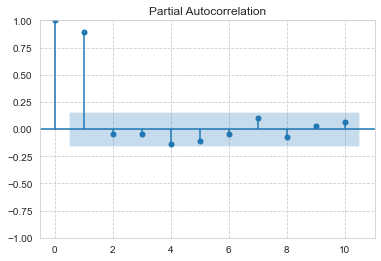

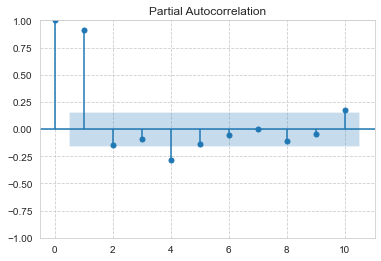

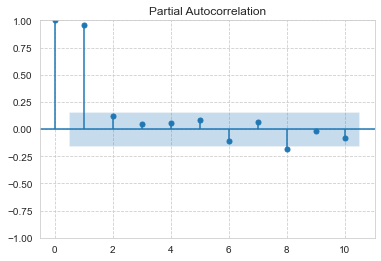

In [217]:
for k in range(K):
    _=plot_pacf(x=model.A[k, :], lags=10)

It validates our assumption to use a AR1 model in the regularization term

# Reconstruction / Regularizatioin / Objective
Study for different values of $\lambda$

In [26]:
def cross_lambda_training(P, K, r_dim, n_mat, max_iter=100):
    """
    DL training for several lambdas
    Parameters
    ----------
    P : ndarray
        migration matrices
    K: int
        number of atoms
    r_dim: int
        matrix dimenion
    n_mat: int
        number of matrices
    max_iter: int
        DL iterations

    
    Returns
    -------
    dict_reco:  dict
    dict_regu:  dict
    dict_obj:  dict
    """
    dict_reco = {}
    dict_regu = {}
    dict_obj = {}
    dict_codings = {}
    LIST_LAMBDAS = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
    for lamb in LIST_LAMBDAS:
        # fit
        model = DictionaryLearning(K=K, r_dim=r_dim, n_mat=n_mat)
        model.fit(P, lamb=lamb, algoA="ar1_l2_mean", algoD="qp", max_iter=max_iter)
        # save
        dict_reco[lamb] = model.list_reconstruction
        dict_regu[lamb] = model.list_regularization
        dict_obj[lamb] = model.list_total_objective
        dict_codings[lamb] = model.A
    return dict_reco, dict_regu, dict_obj, dict_codings

def plot_rro(dict_reco, dict_regu, dict_obj, trunc=0):
    """plot reconstruction, regularization, objective"""

    fig, axes = plt.subplots(3, 1, figsize=(15, 13), sharex=False, squeeze=False)
    # reconstruction, regularization, objective = self.get_rro(P, lamb)
    iterations = np.arange(len(list(dict_reco.values())[0]))[trunc:]
    
    for k, v in dict_reco.items():
        axes[0, 0].plot(iterations, dict_reco[k][trunc:], label=k)
        axes[0, 0].set_title(r"Reconstruction $||P-DA||_F^2$")
        #axes[0, 0].legend(title='Lambda', fontsize=15, title_fontsize=20)
        axes[0, 0].legend(title='Lambda', title_fontsize=15,
                          prop={"size":13}, loc='upper center', bbox_to_anchor=(0.5, 1.5), 
                          fancybox=True, shadow=True, ncol=3)
        #axes[0, 0].set_ylim(0.64, 0.85)


        axes[1, 0].plot(iterations, dict_regu[k][trunc:])
        axes[1, 0].set_title(r"Regularizaton $\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t} - \bar\alpha_k)\right)^2$")

        axes[2, 0].plot(iterations, dict_obj[k][trunc:])
        axes[2,0].set_title(r"Objective $||P-DA||_F^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t} - \bar\alpha_k)\right)^2$")
        axes[2, 0].set_xlabel("DL iterations")

    for i in range(3):
        axes[i, 0].spines["left"].set_color("black")
        axes[i, 0].spines["bottom"].set_color("black")

    return

def plot_codings_lamb(dict_codings, atom, trunc=0):
    """
    compare lambds for a given atom
    """
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 7), sharex=False, squeeze=False)
    # reconstruction, regularization, objective = self.get_rro(P, lamb)
    iterations = np.arange(list(dict_codings.values())[0].shape[1])[trunc:]
    
    for k, v in dict_codings.items():
        axes[0, 0].plot(iterations, dict_codings[k][atom, trunc:], label=k, linewidth=2)
        axes[0, 0].set_title(f"Atom {atom}")
        axes[0, 0].legend(title='Lambda', title_fontsize=15,
                          prop={"size":13}, loc='upper center', bbox_to_anchor=(0.5, 1.3), 
                          fancybox=True, shadow=True, ncol=3)
        #axes[0, 0].set_ylim(0.64, 0.85)


    
    axes[0, 0].spines["left"].set_color("black")
    axes[0, 0].spines["bottom"].set_color("black")

    return


In [22]:
dict_reco, dict_regu, dict_obj, dict_codings = cross_lambda_training(P=P, K=3, 
                                                                    r_dim=11, n_mat=N_MAT, 
                                                                    max_iter=500)

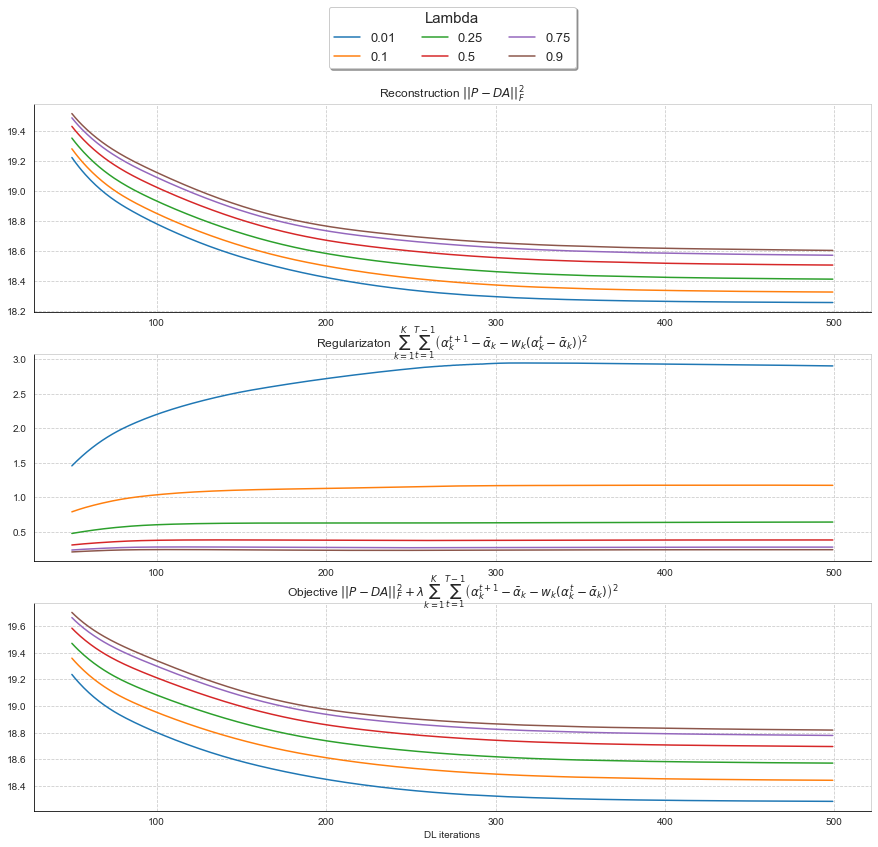

In [27]:
plot_rro(dict_reco_K2, dict_regu_K2, dict_obj_K2, trunc=50)

### Codings

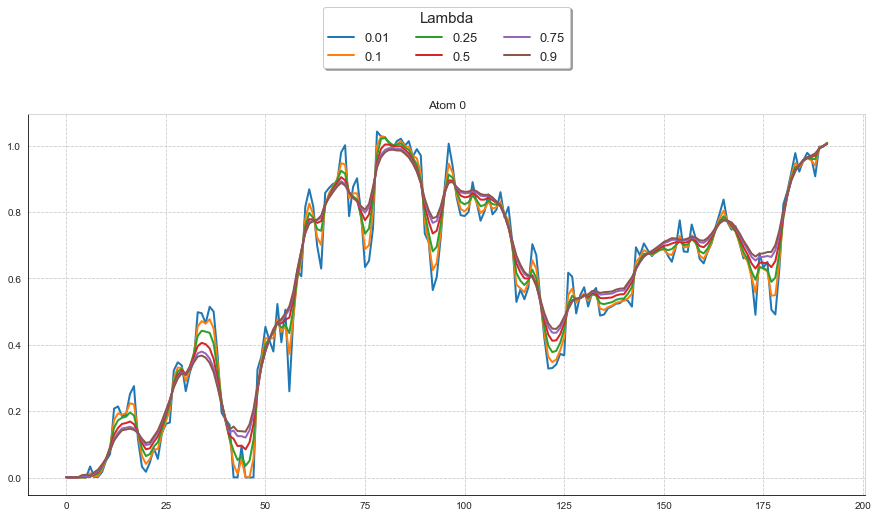

In [28]:
plot_codings_lamb(dict_codings_K2, atom=0)

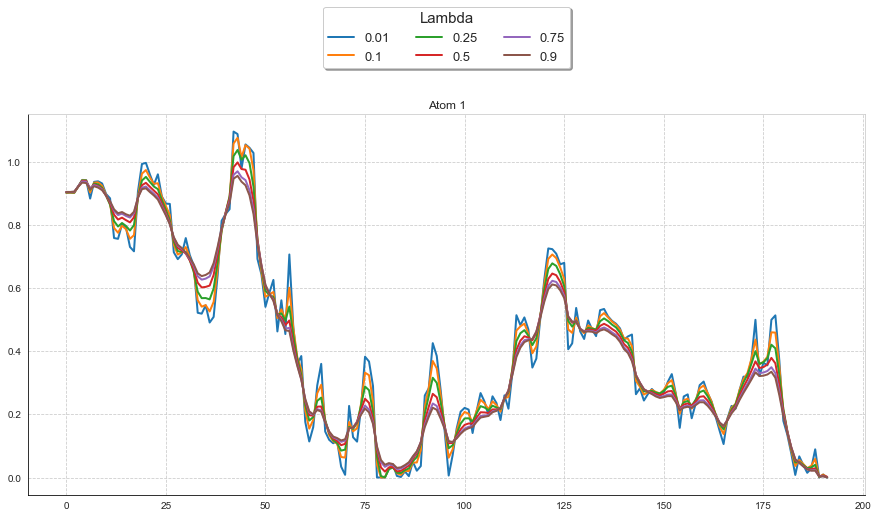

In [29]:
plot_codings_lamb(dict_codings_K2, atom=1)

# Model Selection

In [36]:
IFrame("imgs/model_selection.pdf", width=600, height=600)

In [84]:
df_selection = model_selection(P_train, list_K=[2, 3, 4, 5, 6, 7 , 8 , 9 , 10], 
                               list_lambdas=[0.1, 0.25, 0.5,  0.75, 0.9, 1, 5, 10], 
                                    test_size=0.2, r_dim=11)

/Users/michaelallouche/PhD/repos/dictionary-learning-rmm/dictionary-learning-RMM/models/__init__.py:40: RuntimeWarning: covariance is not positive-semidefinite.
  noise = np.random.multivariate_normal(np.zeros(K), cov, int(n_test) - 1).T


In [85]:
df_selection.astype("float64").round(3)

,0.10,0.25,0.50,0.75,0.90,1.00,5.00,10.00
2,6.680,6.062,5.753,5.631,5.589,5.568,5.393,5.366
3,5.649,5.299,5.028,4.924,4.888,4.869,4.148,4.430
4,5.484,5.034,4.710,4.562,4.500,4.466,3.959,3.711
5,4.709,4.242,3.964,3.872,3.838,3.777,3.635,3.635
6,4.568,4.193,3.991,3.899,3.854,3.828,3.866,3.718
7,4.442,4.081,3.515,3.250,3.145,3.087,2.380,2.452
8,4.843,4.154,3.550,3.159,3.008,2.925,2.326,2.465
9,4.783,3.966,3.030,2.797,3.017,2.997,2.134,2.356
10,4.507,3.242,2.736,2.339,2.273,2.228,1.853,2.178


In [87]:
#df_selection.to_csv("ckpt/model_selection.csv")

# Regularization benefit

In [94]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K = 3
LAMB = 5

In [95]:
A_test_noreg, A_pred_noreg, A_test_reg, A_pred_reg = regularization_benefit(P_train=P_train,
                                                                           P_test=P_test,
                                                                           K=K, lamb=LAMB)

In [96]:
# compute the errors without the first testing values
error_reg = np.linalg.norm(A_test_reg[:, 1:] - A_pred_reg) ** 2
error_noreg = np.linalg.norm(A_test_noreg[:, 1:] - A_pred_noreg) ** 2

print("SFro error REG: {:.3f}".format(error_reg))
print("SFro error NO-REG: {:.3f}".format(error_noreg))

SFro error REG: 0.158
SFro error NO-REG: 0.238


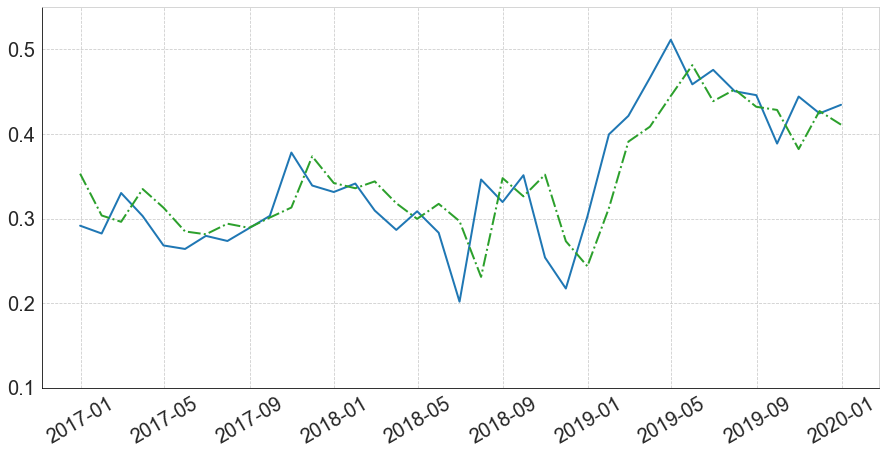

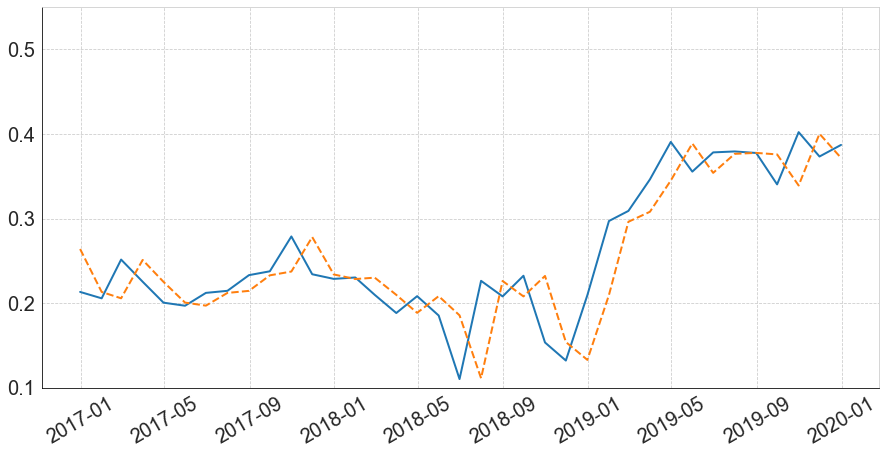

In [242]:
ATOM = 3

# NO REG
# -------
fig, ax = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
ax.plot(dates[n_train+1:], A_test_noreg[ATOM-1, 1:], label="test", linewidth=2)
ax.plot(dates[n_train+1:], A_pred_noreg[ATOM-1, :], label="no_reg", linewidth=2, color="C2",  linestyle="-.")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

#ax.set_ylim(-0.1, 0.4)
ax.set_ylim(0.1, 0.55)

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#_=plt.legend()
#plt.savefig("imgs/predictions/noreg-K{}-lamb{}-atom{}.eps".format(K, 0, ATOM), format"eps")
# ----------


# REG
# -------

fig, ax = plt.subplots(1, 1, figsize=(15, 7), sharex=True)
ax.plot(dates[n_train+1:], A_test_reg[ATOM-1, 1:], label="test", linewidth=2)
ax.plot(dates[n_train+1:], A_pred_reg[ATOM-1, :], label="reg", linewidth=2, linestyle="--")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

#ax.set_ylim(-0.1, 0.4)
ax.set_ylim(0.1, 0.55)

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#_=plt.legend()
#plt.savefig("imgs/predictions/reg-K{}-lamb{}-atom{}.eps".format(K, LAMB, ATOM), format"eps")
# -------

# Comparaison AR and DL

In [223]:
K = 3
LAMB = 5

model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=LAMB, max_iter=500)

In [224]:
# fit AR model on the training codings A_train
list_paramsAR= []  
for atom in range(K):
    ar_model = AutoReg(model.A[atom, :], lags=1).fit()
    list_paramsAR.append(ar_model.params)

mat_paramsAR = np.array(list_paramsAR)
mat_paramsDL = np.concatenate([model.mu.reshape(-1,1), model.W.reshape(-1,1)], axis=1)

Compute
\begin{align*}
    &w^{AR} - w^{DL},\\ &\mu^{AR} - \mu^{DL}
\end{align*}

In [225]:
# Difference between parameters AR and DL
pd.DataFrame(mat_paramsDL-mat_paramsAR, columns=["constant", "drift"])

,constant,drift
0,0.001978,-0.000158
1,-0.001146,-0.000200
2,-0.001430,-0.000004


# Dictionary

In [226]:
for atom in range(1, K+1):
    display(Latex("$d_{}$".format(atom)))
    display(pd.DataFrame(model.inv_vectorized(model.D[:, atom-1], 10, 11),
                        index=np.arange(1, 11), columns=np.arange(1, 12)).round(4)*100)

<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,91.15,6.23,0.00,1.34,0.09,0.78,0.31,0.09,0.01,0.00,0.00
2,0.33,93.76,3.28,0.92,0.52,0.70,0.39,0.09,0.01,0.00,0.00
3,0.33,5.08,79.22,10.94,3.02,0.93,0.39,0.09,0.01,0.00,0.00
4,0.01,1.35,6.70,82.94,5.36,3.14,0.39,0.09,0.01,0.00,0.00
5,0.01,0.26,0.92,6.31,80.00,9.83,2.04,0.62,0.01,0.00,0.00
6,0.00,0.02,0.55,0.72,6.53,85.39,5.85,0.92,0.01,0.00,0.00
7,0.00,0.02,0.07,0.25,0.36,5.57,88.71,5.01,0.01,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.03,4.70,95.25,0.01,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,4.73,17.51,77.75,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.36,11.32,0.00,88.31,0.02


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,8.96,62.72,24.10,2.13,0.71,0.00,0.00,0.88,0.20,0.29,0.01
3,1.46,14.81,79.46,0.00,0.73,1.80,0.04,0.90,0.31,0.33,0.16
4,1.09,0.48,22.68,64.39,7.07,1.44,1.03,0.89,0.34,0.38,0.21
5,1.09,0.48,3.87,30.64,53.99,6.99,0.81,0.32,0.54,0.98,0.29
6,0.59,0.96,0.68,4.27,30.61,46.99,9.25,3.14,0.89,1.52,1.10
7,0.58,0.78,0.84,1.16,6.28,33.25,32.96,16.23,4.19,1.27,2.46
8,0.58,0.73,0.86,0.77,2.66,9.46,38.28,26.17,9.71,5.31,5.47
9,0.58,0.73,0.79,0.79,2.72,4.11,10.81,0.00,67.96,5.87,5.64
10,0.00,0.00,0.00,0.00,1.18,1.25,18.10,0.00,48.08,0.00,31.40


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,67.95,21.42,4.89,3.47,0.46,1.16,0.00,0.00,0.00,0.00,0.65
2,0.00,81.99,11.23,4.51,0.46,0.62,0.16,0.01,0.21,0.16,0.65
3,0.00,0.00,91.51,6.22,0.46,0.62,0.16,0.01,0.20,0.17,0.65
4,0.00,0.00,0.00,81.95,16.24,0.62,0.16,0.01,0.19,0.18,0.65
5,0.00,0.00,0.00,2.90,84.93,7.16,2.22,0.96,0.54,0.64,0.65
6,0.00,0.00,0.00,1.22,4.96,72.83,14.44,1.58,1.55,0.99,2.43
7,0.00,0.00,0.00,0.52,1.62,5.94,75.69,9.45,3.29,0.75,2.73
8,0.00,0.00,0.00,0.21,0.90,0.98,20.69,56.90,10.27,3.64,6.41
9,0.00,0.00,0.00,0.21,0.14,1.74,0.00,16.18,0.00,31.80,49.93
10,0.00,0.00,0.00,0.00,0.00,0.00,2.09,2.54,0.00,43.01,52.36


# Clustering (K-Means)

In [129]:
# Model
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K = 3
LAMB = 5

# build train model
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=LAMB, max_iter=500)

In [130]:
# projection of P^test on D^train
A_test = np.linalg.inv(model.D.T @ model.D) @ model.D.T @ P_test  # real
# Predicitoin of codings
A_pred = model.mu.reshape(-1, 1) + (model.W.reshape(-1, 1) * A_test[:, :-1])

In [131]:
# Stadardization of training codings
A_mean = model.A.mean(axis=1).reshape(-1,1)
A_std = model.A.std(axis=1).reshape(-1,1)
A_scaled = ((model.A - A_mean) / A_std).T

In [132]:
def plot_3Clusters(X):
    fig, ax = plt.subplots(1, 1, figsize=(12,7))
    print(X.shape)

    ax.scatter(dates[:n_train][np.where(X == 2)[0]], 
                -1*np.ones_like(np.where(X == 2)[0]), 
                color="orange")

    ax.scatter(dates[:n_train][np.where(X == 1)[0]], 
                -1*np.ones_like(np.where(X == 1)[0]), 
                color="red")

    ax.scatter(dates[:n_train][np.where(X == 0)[0]], 
                np.ones_like(np.where(X == 0)[0]), 
                color="green")

    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")

    plt.xlabel("time", fontsize=20)
    plt.ylabel("Clustering", fontsize=20)
    return

In [133]:
N_CLUSTERS = 3
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

KMeans(init='random', n_clusters=3, random_state=42)

In [134]:
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

# Final locations of the centroids
kmeans.cluster_centers_

array([[-0.75143068, -0.77573802,  1.10771007],
       [-0.37102257,  1.17085487, -0.27911151],
       [ 1.2053922 , -0.21626224, -1.00042466]])

In [135]:
# Final predictions
y_train_pred = kmeans.labels_
y_train_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

Train


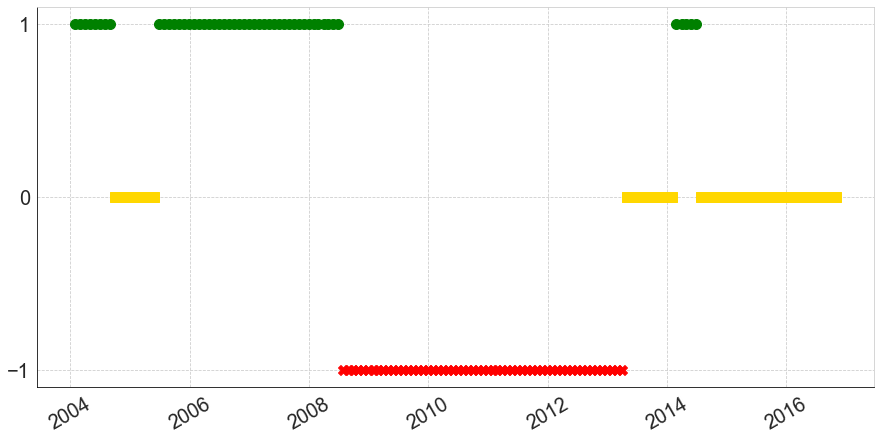

In [258]:
dict_labels={"green": 2, "gold":1, "red":0}


fig, ax = plt.subplots(1, 1, figsize=(15,7),)

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["red"])[0]], 
            -1*np.ones_like(np.where(y_train_pred == dict_labels["red"])[0]), 
            color="red", s=100, marker="X")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["gold"])[0]], 
            np.zeros_like(np.where(y_train_pred == dict_labels["gold"])[0]), 
            color="gold", s=100, marker="s")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["green"])[0]], 
            np.ones_like(np.where(y_train_pred == dict_labels["green"])[0]), 
            color="green", s=100, marker="o")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

print("Train")
plt.savefig("imgs/clustering/cluster_train-K{}-lamb{}.eps".format(K, LAMB), format="eps")
#plt.xlabel("time", fontsize=20)
#plt.ylabel("Clustering", fontsize=20)
#_ = plt.title("Clustering on the Train set", fontsize="20")

Test


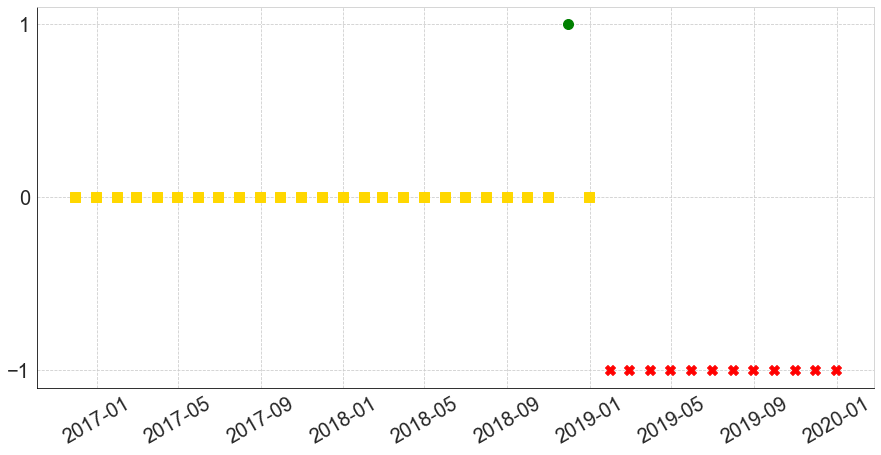

In [259]:
# clustering prediction on AR predictions
A_test_scaled = (A_test - A_mean) / A_std
y_test_pred = kmeans.predict(A_test_scaled.T)

fig, ax = plt.subplots(1, 1, figsize=(15,7),)
plt.scatter(dates[n_train:][np.where(y_test_pred == dict_labels["red"])[0]], 
            -1*np.ones_like(np.where(y_test_pred == dict_labels["red"])[0]), 
            color="red", s=100, marker="X")

ax.scatter(dates[n_train:][np.where(y_test_pred == dict_labels["gold"])[0]], 
            np.zeros_like(np.where(y_test_pred == dict_labels["gold"])[0]), 
            color="gold", s=100, marker="s")

ax.scatter(dates[n_train:][np.where(y_test_pred == dict_labels["green"])[0]], 
            np.ones_like(np.where(y_test_pred == dict_labels["green"])[0]), 
            color="green", s=100, marker="o")


ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

print("Test")
plt.savefig("imgs/clustering/cluster_test-K{}-lamb{}.eps".format(K, LAMB), format="eps")

#plt.xlabel("time", fontsize=20)
#plt.ylabel("Clustering", fontsize=20)
#plt.ylim(-1.1, 1.1)
#_ = plt.title("Clustering on the Test set", fontsize="20")

## Study of the associated atoms

$$\bar\alpha^{{red}}_k = \frac{1}{T^{red}}\sum_{t=1}^{T^{red}}\alpha_k^t$$


In [202]:
# dictionary
for atom in range(K):
    display(Latex("$\check d{}$".format(atom+1)))
    display(pd.DataFrame(model.inv_vectorized(model.D[:, atom], 10, 11)).round(4)*100)

<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,91.15,6.23,0.00,1.34,0.09,0.78,0.31,0.09,0.01,0.00,0.00
1,0.33,93.76,3.28,0.92,0.52,0.70,0.39,0.09,0.01,0.00,0.00
2,0.33,5.08,79.22,10.94,3.02,0.93,0.39,0.09,0.01,0.00,0.00
3,0.01,1.35,6.70,82.94,5.36,3.14,0.39,0.09,0.01,0.00,0.00
4,0.01,0.26,0.92,6.31,80.00,9.83,2.04,0.62,0.01,0.00,0.00
5,0.00,0.02,0.55,0.72,6.53,85.39,5.85,0.92,0.01,0.00,0.00
6,0.00,0.02,0.07,0.25,0.36,5.57,88.71,5.01,0.01,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.03,4.70,95.25,0.01,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,4.73,17.51,77.75,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.36,11.32,0.00,88.31,0.02


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,8.96,62.72,24.10,2.13,0.71,0.00,0.00,0.88,0.20,0.29,0.01
2,1.46,14.81,79.46,0.00,0.73,1.80,0.04,0.90,0.31,0.33,0.16
3,1.09,0.48,22.68,64.39,7.07,1.44,1.03,0.89,0.34,0.38,0.21
4,1.09,0.48,3.87,30.64,53.99,6.99,0.81,0.32,0.54,0.98,0.29
5,0.59,0.96,0.68,4.27,30.61,46.99,9.25,3.14,0.89,1.52,1.10
6,0.58,0.78,0.84,1.16,6.28,33.25,32.96,16.23,4.19,1.27,2.46
7,0.58,0.73,0.86,0.77,2.66,9.46,38.28,26.17,9.71,5.31,5.47
8,0.58,0.73,0.79,0.79,2.72,4.11,10.81,0.00,67.96,5.87,5.64
9,0.00,0.00,0.00,0.00,1.18,1.25,18.10,0.00,48.08,0.00,31.40


<IPython.core.display.Latex object>

,0,1,2,3,4,5,6,7,8,9,10
0,67.95,21.42,4.89,3.47,0.46,1.16,0.00,0.00,0.00,0.00,0.65
1,0.00,81.99,11.23,4.51,0.46,0.62,0.16,0.01,0.21,0.16,0.65
2,0.00,0.00,91.51,6.22,0.46,0.62,0.16,0.01,0.20,0.17,0.65
3,0.00,0.00,0.00,81.95,16.24,0.62,0.16,0.01,0.19,0.18,0.65
4,0.00,0.00,0.00,2.90,84.93,7.16,2.22,0.96,0.54,0.64,0.65
5,0.00,0.00,0.00,1.22,4.96,72.83,14.44,1.58,1.55,0.99,2.43
6,0.00,0.00,0.00,0.52,1.62,5.94,75.69,9.45,3.29,0.75,2.73
7,0.00,0.00,0.00,0.21,0.90,0.98,20.69,56.90,10.27,3.64,6.41
8,0.00,0.00,0.00,0.21,0.14,1.74,0.00,16.18,0.00,31.80,49.93
9,0.00,0.00,0.00,0.00,0.00,0.00,2.09,2.54,0.00,43.01,52.36


**Plot the repartition of the RED cluster**

In [213]:
# labels associated with the red cluster
cluster_times = np.where(y_train_pred == (dict_labels["red"]))[0]
cluster_times

array([ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110])

In [214]:
# average the associated codings alpha
alpha_avg = model.A[:, cluster_times].mean(axis=1) #.round(1)
alpha_avg

array([0.56249502, 0.0661672 , 0.36747743])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


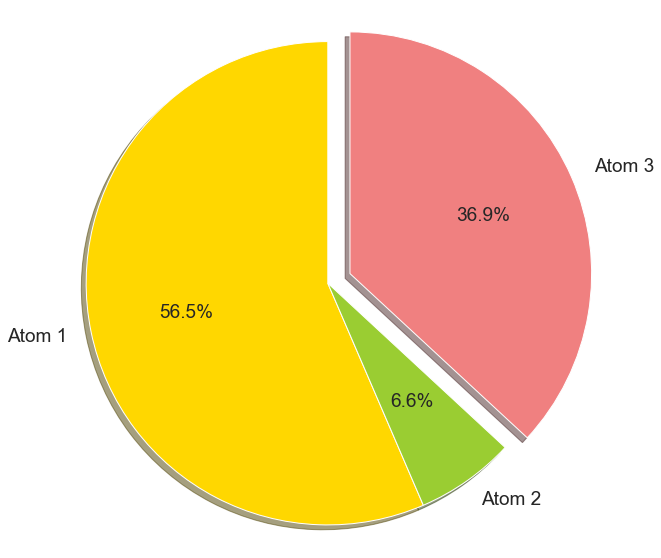

In [261]:
atoms = ["Atom {}".format(k) for k in np.arange(1, K+1)]
fig, ax = plt.subplots(figsize=(10, 10))
explode = (0, 0, 0.1)  # explode 1st slice
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink', "lightgray"]
colors = ['gold', 'yellowgreen', 'lightcoral']


ax.pie(alpha_avg, labels=atoms, explode=explode, autopct='%.1f%%',
       colors=colors, shadow=True, startangle=90, textprops={'fontsize': 19}) # 

_=plt.axis('equal')
#plt.savefig("imgs/clustering/pie_train-group{}.eps".format(dict_labels["red"]), format="eps")